# 🧠 Selección y extracción de Características  

En esta fase se busca **reducir la dimensionalidad** del conjunto de datos y conservar únicamente aquellas características más relevantes para la tarea de clasificación binaria (*imagen manipulada* vs *imagen no manipulada*).  

Tras la extracción de características (Fase 02), cada imagen fue representada mediante un vector de **n atributos**, incluyendo descriptores como HOG, GLCM, LBP, entre otros. Sin embargo, no todas estas variables aportan información útil al modelo; algunas pueden ser redundantes o incluso introducir ruido.  

Por esta razón, se implementaron **tres estrategias complementarias de selección de características**:  

---

## ✅ Métodos Utilizados  

### 1️⃣ Análisis de Varianza (ANOVA) - F-Score
- Este método estadístico evalúa la capacidad discriminativa de cada característica individualmente, comparando la varianza **entre clases** con la varianza **dentro de la misma clase**.

---

### 2️⃣ Recursive Feature Elimination (RFE)  
- RFE utiliza un modelo de machine learning (RF en este caso) para evaluar la importancia de las características y eliminar de forma recursiva aquellas menos relevantes.

---

### 3️⃣ Análisis de Componentes Principales (PCA)  
- PCA no es estrictamente un método de selección, sino de **reducción de dimensionalidad**.  
- Se proyectaron las características en un espacio de menor dimensión, manteniendo las componentes principales que explican la mayor varianza del conjunto de datos.  
- Esta técnica es especialmente útil para eliminar colinealidad entre atributos y acelerar el entrenamiento de los modelos.  

---

## 🎯 Resultado Esperado  
Al finalizar esta fase:  
✅ Se obtendrá un conjunto reducido de características relevantes.  
✅ Se almacenará en un archivo `data_reduced.npz` para su uso en la fase siguiente (*entrenamiento y validación de modelos*).  
✅ Esto permitirá construir modelos más ligeros, con mejor generalización y menor riesgo de sobreajuste.  

---

📂 **Output de la Fase 03**  
- NPZ con características seleccionadas (`data_reduced.npz`).  
- Gráficos de importancia de variables y varianza explicada.  

In [34]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_curve, auc
)
import seaborn as sns

In [35]:

def select_features_filter(X, y, feature_names, k=20, plot=True):
 
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    mask = selector.get_support()  # True para características seleccionadas
    
    # F-scores
    f_scores = pd.Series(selector.scores_, index=feature_names)
    f_scores_sorted = f_scores.sort_values(ascending=False)
    
    # Características seleccionadas
    selected_features = f_scores_sorted.index[:k].tolist()
    
    if plot:
        plt.figure(figsize=(10, 5))
        f_scores_sorted.plot(kind='bar', color='skyblue')
        plt.title("Importancia de las características (ANOVA F-score)")
        plt.ylabel("F-score")
        plt.xlabel("Características")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    return X_new, selected_features, f_scores_sorted

def rfe_with_random_forest(X, y, n_features_to_select=10, test_size=0.2, random_state=42, plot=True):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Modelo base Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state)

    # Aplicar RFE
    rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Variables seleccionadas
    selected_features = X.columns[rfe.support_].tolist()
    print("📌 Características seleccionadas:", selected_features)

    # Entrenar modelo RF sobre las características seleccionadas
    rf.fit(X_train[selected_features], y_train)

    # Evaluar
    y_pred = rf.predict(X_test[selected_features])
    y_prob = rf.predict_proba(X_test[selected_features])[:, 1]
    print("📊 Reporte de clasificación:\n", classification_report(y_test, y_pred))

    if plot:
        # 🎨 Importancia de características
        importances = pd.Series(rf.feature_importances_, index=selected_features)
        importances = importances.sort_values(ascending=False)
        plt.figure(figsize=(10, 5))
        importances.plot(kind='bar', color='skyblue')
        plt.title("Importancia de características (Random Forest)")
        plt.ylabel("Importancia")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # 🎨 Curva ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title("Curva ROC")
        plt.xlabel("Tasa de Falsos Positivos")
        plt.ylabel("Tasa de Verdaderos Positivos")
        plt.legend()
        plt.show()


    return selected_features, rf

def reduce_with_pca(X, n_components=20, plot=True):

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)

    # Obtener estadísticas
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    pca_df = pd.DataFrame({
        "Componente": [f"PC{i+1}" for i in range(n_components)],
        "Varianza_Explicada": explained_variance,
        "Varianza_Acumulada": cumulative_variance
    })

    print("📊 Resumen PCA:")
    print(pca_df)

    if plot:
        # 🎨 Gráfico de varianza explicada
        plt.figure(figsize=(10, 5))
        plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, align='center',
                label="Varianza explicada")
        plt.step(range(1, n_components + 1), cumulative_variance, where='mid',
                 label="Varianza acumulada", color='red')
        plt.xlabel('Componentes principales')
        plt.ylabel('Varianza explicada')
        plt.title('Varianza explicada por componente (PCA)')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    return X_pca, pca, pca_df


In [36]:
#lectura de características
'''
data = np.load("data.npz")

X = data['X']
y = data['y']
grupos = data['groups']
'''
data = np.load("data.pkl", allow_pickle=True)

X = data.drop(columns=['uuid', 'label'])
y = data['label'].values
print(f'Dimensiones de X: {X.shape}')

Dimensiones de X: (790, 30)


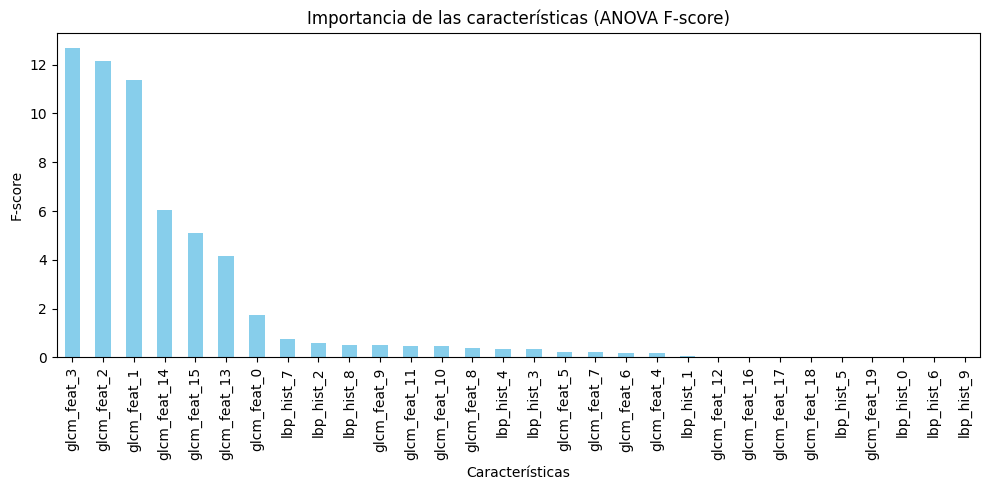

📌 Características seleccionadas: ['lbp_hist_0', 'lbp_hist_3', 'lbp_hist_4', 'lbp_hist_5', 'lbp_hist_6', 'lbp_hist_7', 'lbp_hist_8', 'lbp_hist_9', 'glcm_feat_0', 'glcm_feat_1', 'glcm_feat_2', 'glcm_feat_3', 'glcm_feat_4', 'glcm_feat_6', 'glcm_feat_12', 'glcm_feat_13', 'glcm_feat_14', 'glcm_feat_15', 'glcm_feat_16', 'glcm_feat_17']
📊 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.78      0.85        45
           1       0.92      0.98      0.95       113

    accuracy                           0.92       158
   macro avg       0.93      0.88      0.90       158
weighted avg       0.93      0.92      0.92       158



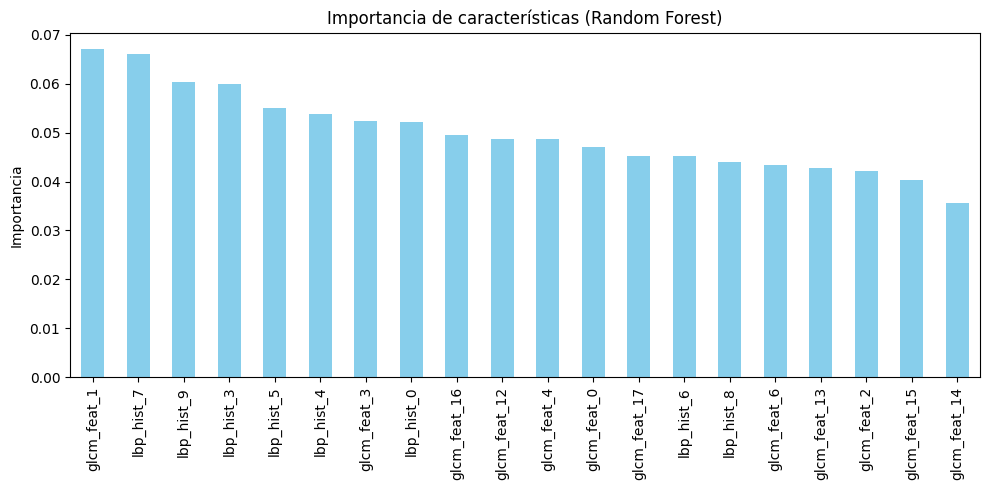

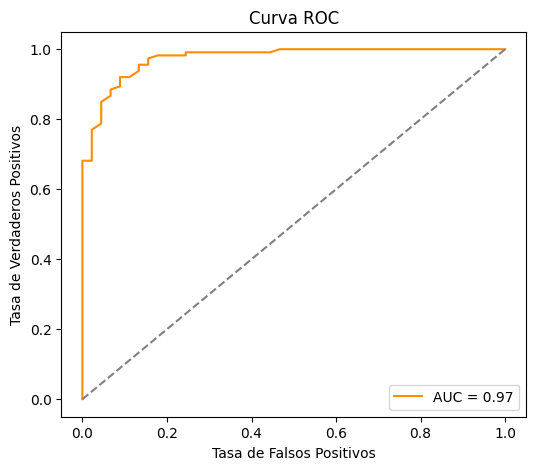

📊 Resumen PCA:
   Componente  Varianza_Explicada  Varianza_Acumulada
0         PC1        9.756604e-01            0.975660
1         PC2        1.406466e-02            0.989725
2         PC3        8.169334e-03            0.997894
3         PC4        2.085886e-03            0.999980
4         PC5        1.946904e-05            1.000000
5         PC6        1.802024e-07            1.000000
6         PC7        3.122678e-08            1.000000
7         PC8        9.918452e-09            1.000000
8         PC9        3.688575e-09            1.000000
9        PC10        1.386801e-09            1.000000
10       PC11        8.317668e-10            1.000000
11       PC12        4.615604e-10            1.000000
12       PC13        1.950465e-10            1.000000
13       PC14        1.393200e-10            1.000000
14       PC15        7.131239e-11            1.000000
15       PC16        6.155286e-11            1.000000
16       PC17        4.497802e-11            1.000000
17       PC18

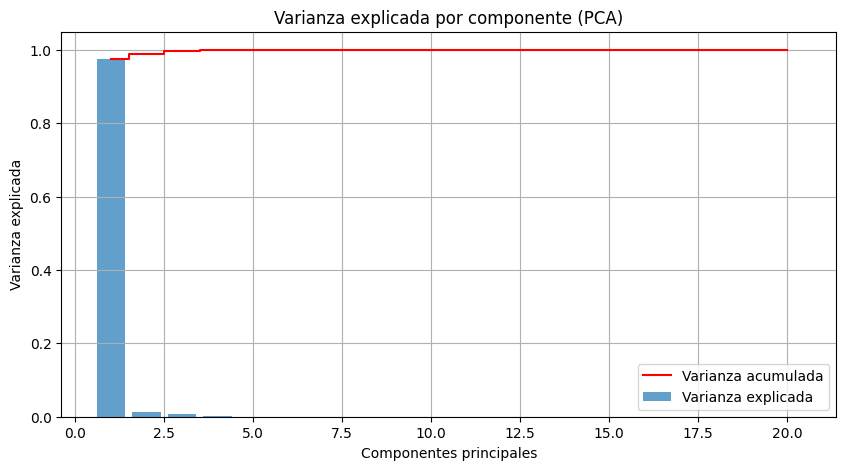

  Componente  Varianza_Explicada  Varianza_Acumulada
0        PC1            0.975660            0.975660
1        PC2            0.014065            0.989725
2        PC3            0.008169            0.997894
3        PC4            0.002086            0.999980
4        PC5            0.000019            1.000000


In [37]:
#comp = X.shape[1]//3
comp = 20  # Número de componentes a seleccionar

X_new, mask, _ = select_features_filter(X=X.values, y=y, feature_names=X.columns, k=comp, plot=True)
X_rfe, rf_model = rfe_with_random_forest(X=X, y=y, n_features_to_select=comp, plot=True)
X_pca, pca_model, pca_stats = reduce_with_pca(X=X.values, n_components=comp, plot=True)
print(pca_stats.head())

#X_pca, pca = reduce_with_pca(X, n_components=comp)

In [38]:
np.savez_compressed("data_reduce.npz", X=X_new, y=y, grupos=grupos) # X de la selección por filtro
#np.savez_compressed("data_reduce.npz", X=X_rfe, y=y, grupos=grupos) # X de la selección RFE
#np.savez_compressed("data_reduce.npz", X=X_pca, y=y, grupos=grupos) # X reducido con PCA